# Monte Carlo Markov Chains (MCMC)

MCMC methods are algorithms that uses Markov Chains to perform Monte Carlo estimation. The major application of MCMC is to generate an array of samples coming from an unknown distribution. Throughout the process of generation, the samples _converges_. However, the convergence in this case does not mean the values converge into a single point, but rather they converge to a distribution of possible points. 

In this exercise 3 popular sampling methods will be used to sample from bivariate gaussian distribution. MCMC will be also used to sample from complex distribution and to make an educated guess about the _posteriori_ distribution. 

## Sampling from a bivariate Gaussian

MCMC will be used to draw samples from bivariate gaussian distribution. Obviously, the method applied here is not the best one for sampling from gaussian. Instead, the goal is to implement sampling methods. 


In [35]:
import itertools
import math
import random
import time
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [58]:
def plot_samples(
    samples1: np.ndarray, 
    samples2: Optional[np.ndarray] = None,
    mean: Optional[Tuple[float, float]] = None,
) -> None:
    
    fig, ax = plt.subplots()
    plt.grid()
    ax.scatter(samples1[:,0], samples1[:,1], 
               marker="x", color="green", label='observed')
    if mean is not None:
        ax.scatter(*mean, marker='o', c='r', label='observed mean')
    if samples2 is not None:
        ax.scatter(samples2[:,0], samples2[:,1], 
                   marker="x", color="orange", label='generated')
    plt.legend()
    plt.show()

In [99]:
class UnivariateGaussian:
    
    def __init__(self, mean: float, std: float):
        """Univariate Gaussian distribution."""
        self.mean = mean
        self.std = std
        
    def sample(self, n_samples: int = 1) -> np.ndarray:
        """Sampling from the distribution."""
        return np.random.normal(self.mean, self.std, n_samples)

The bivariate gaussian methods were implemented following video: https://www.youtube.com/watch?v=fb8uE4NM2fc

- x1_cond_x2: conditional distribution $p(x_1 | x_2)$
- x2_cond_x1: conditional distribution $p(x_2 | x_1)$

In [100]:
class BivariateGaussian:
    
    def __init__(
        self, 
        mean1: float, std1: float, 
        mean2: float, std2: float, 
        p: float,
    ):
        """Bivariate Gaussian Distribution.
        
        Parameters:
        -----------
        mean1
            Mean parameter of the first coordinate.
        sdt1
            Standard deviation parameter of the first coordinate.
        mean2
            Mean parameter of the second coordinate.
        std2
            Standard deviation parameter of the second coordinate.
        p
            The correlation coefficient.
        """
        self.mean1 = mean1
        self.std1 = std1
        self.mean2 = mean2
        self.std2 = std2
        self.p = p
        
        # Bivariate gaussian vector of means.
        self.mean: np.ndarray = np.array([self.mean1, self.mean2])
        # Bivariate gaussian covariance matrix.
        self.cov: np.ndarray = np.array([
            [self.std1 ** 2, self.p * self.std1 * self.std2],
            [self.p * self.std1 * self.std2, self.std2 ** 2],
        ])
        
        # Marginal distributions.
        self.marginal_x1 = UnivariateGaussian(
            self.mean1, self.std1)
        self.marginal_x2 = UnivariateGaussian(
            self.mean2, self.std2)
        
    def sample(self, n_samples: int = 1) -> np.ndarray:
        return np.random.multivariate_normal(
            self.mean, self.cov, n_samples)
    
    def pdf(self, x: np.ndarray) -> Union[np.ndarray, float]:
        return scipy.stats.multivariate_normal.pdf(
            x, mean=self.mean, cov=self.cov)
        
    def x1_cond_x2(self, x2: float) -> UnivariateGaussian:
        mean = self.mean1 + (
            self.p * self.std1 * (x2 - self.mean2)
        ) / self.std2
        std = (1 - self.p**2) * self.std1**2

        return UnivariateGaussian(mean, std)

    def x2_cond_x1(self, x1: float) -> UnivariateGaussian:
        mean = self.mean2 + (
            self.p * self.std2 * (x1 - self.mean1)
        ) / self.std1
        std = (1 - self.p**2) * self.std2**2

        return UnivariateGaussian(mean, std)

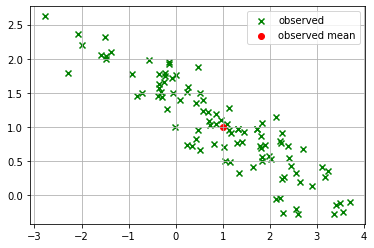

In [101]:
mean1, std1 = 1, 1.5
mean2, std2 = 1, 0.7
corr = -0.9

bivariate_gaussian = BivariateGaussian(mean1, std1, mean2, std2, corr)

plot_samples(target_bi_gaussian.sample(100), mean=(mean1,mean2))

### Ancestral sampling

The first sampling method samples from $p(x_1, x_2)$ as follows:

1. sample $x_1$: $x_1 \sim p(x_1)$
2. sample $x_2$: $x_2 \sim p(x_2 | x_1)$

In [71]:
def ancestral_sampling(n_samples: int) -> np.ndarray:
    x1 = np.empty((n_samples, ))
    x2 = np.empty((n_samples, ))

    # First step, sample from univariate gaussian.
    x1[:] = bivariate_gaussian.marginal_x1.sample(n_samples)
    for i in range(n_samples):
        # For each value from x1 sample x2 from conditional distribution.
        x2[i] = bivariate_gaussian.x2_cond_x1(x1[i]).sample(1)

    samples = np.stack([x1, x2], axis=1)
    
    return samples

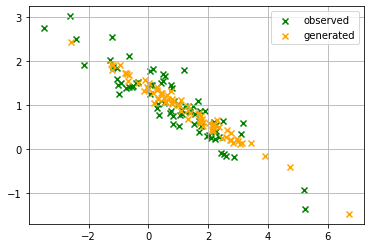

In [72]:
n_samples = 75

plot_samples(
    target_bi_gaussian.sample(n_samples), 
    ancestral_sampling(n_samples),
)

### Gibbs sampling

The algorithm for Gibbs sampling is relatively simple as well. It requires to set initial value $x^{(0)} = (x_1^{(0)}, x_2^{(0)})$. To generate $N$ samples the we simply repeat for each $i$ in $1, 2, 3, ..., N$:
1. sample $x_1^{(i)} \sim p(x_1^{(i)} | x_2^{(i-1)}) $
2. sample $x_2^{(i)} \sim p(x_2^{(i)} | x_1^{(i)})$

In addition, burning and skipping samples was added.

In [75]:
def gibbs_sampling(
    n_samples: int, burning: int = 0, skip: int = 0,
) -> np.ndarray:
    
    # Initialize x.
    point = np.zeros(2)
    
    samples = np.empty((n_samples, 2))
    n_sampled = 0
    
    for i in itertools.count(start=0):
        # Sample p(x1^(i) | x2^(i-1))
        point[0] = bivariate_gaussian.x1_cond_x2(point[1]).sample(1)
        # Sample p(x2^(i) | x1^(i))
        point[1] = bivariate_gaussian.x2_cond_x1(point[0]).sample(1)
        
        # Samples burning and skipping.
        if i >= burning and (i - burning) % (skip + 1) == 0:
            samples[n_sampled] = point
            n_sampled += 1
            
            if n_sampled == n_samples:
                break

    return samples

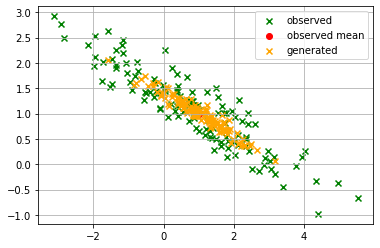

In [107]:
n_samples = 125
burning = 200
skip = 75

plot_samples(
    target_bi_gaussian.sample(n_samples), 
    gibbs_sampling(n_samples, burning=burning, skip=skip),
    mean=(mean1, mean2),
)

### Metropolis–Hastings sampling

Metropolis–Hastings requires arbitrary initial point $x^{(0)}$ and distribution $Q$ that will be used for sampling candidates. Here, $Q$ is going to be a bivariate gaussian distribution with mean vector equal to previous point and starndard deviation of the value provided as the function parameter. The algorithm generates a candidate from distribution $Q$ and later compares its PDF to compute a ratio that is compared against a random number. Hence, the algorithm accepts or rejects candidates. It is worth to check on acceptance ratio since its low value may give evidence for wrong parameter values and poor sampling performance.

The sampling can be summarized in the following steps:
1. Initialize $x_t=x^{(0)}, Q$.
2. Generate candidate $x_c \sim Q(.|x_t)$.
3. Calculate acceptance ratio $a = f(x_c)/f(x_t)$. $f$ proportional to the target density function.
4. Generate random variable $u \sim U(0,1)$, if $a \le u$ accept and set $x_t=x_c$ otherwise reject.

In [102]:
def metropolis_sampling(
    n_samples: int, noise_std: float = 1.,
    burning: int = 0, skip: int = 0
) -> np.ndarray:
    
    point = np.zeros(2)
    samples = np.empty((n_samples, 2))
    
    n_sampled = 0
    accepted = 0
    rejected = 0
    for i in itertools.count(start=0):
        # Sampling a candidate.
        candidate = BivariateGaussian(
            mean1=point[0], std1=noise_std,
            mean2=point[1], std2=noise_std, p=0
        ).sample(1)[0]
        
        # Acceptance ratio.
        a = min(
            1, 
            bivariate_gaussian.pdf(candidate) / bivariate_gaussian.pdf(point),
        )
        u = np.random.uniform()
        # Accept or reject.
        if u < a:
            point = candidate
            accepted += 1
        else:
            rejected += 1
            
        # Samples burning and skipping.
        if i >= burning and (i - burning) % (skip + 1) == 0:
            samples[n_sampled] = candidate
            n_sampled += 1
            if n_sampled == n_samples:
                break

    print("Acceptance rate: ", accepted / (accepted + rejected))
    return samples

Acceptance rate:  0.7804699738903395


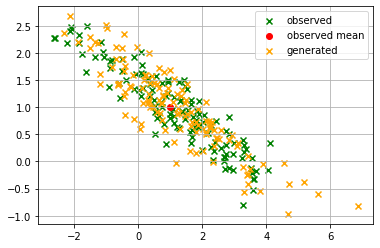

In [108]:
n_samples = 125
burning = 150
skip = 75
noise_std = .2

plot_samples(
    target_bi_gaussian.sample(n_samples),
    metropolis_sampling(n_samples, noise_std, 
                        burning=burning, skip=skip),
    mean=(mean1, mean2),
)